# TFLego MNIST Examples

## Preliminary

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [15]:
from os import path
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image as Image
import sys
import tensorflow as tf

sys.path.append("..")
sys.path.append("../utils")

from tflego import blocks
from tflego import seq2seq
from tflego import training
from tflego.blocks import NP_DTYPE, TF_DTYPE, NP_ITYPE, TF_ITYPE
import plotting

In [3]:
output_dir = "/tmp/data/"

## Load MNIST data

In [4]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets(output_dir, one_hot=True)

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


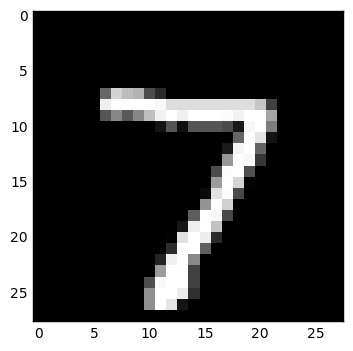

In [5]:
plt.imshow(np.reshape(mnist.test.images[0, :], (28, 28)), cmap="Greys_r", interpolation="nearest")

## Feedforward neural network

In [6]:
tf.reset_default_graph()

# Training parameters
learning_rate = 0.001
n_epochs = 5
batch_size = 100
ff_keep_prob = 0.75

# Model parameters
n_input = 28*28
n_classes = 10
n_hiddens = [256, 256]

# Model
x = tf.placeholder(TF_DTYPE, [None, n_input])
y = tf.placeholder(TF_DTYPE, [None, n_classes])
keep_prob = tf.placeholder(TF_DTYPE)
ff = blocks.build_feedforward(x, n_hiddens, keep_prob)
with tf.variable_scope("ff_layer_final"):
    ff = blocks.build_linear(ff, n_classes)

# Training tensors
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(ff, y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

# Test tensors
correct_prediction = tf.equal(tf.argmax(ff, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

In [562]:
# Train model

def mnist_train_feed_iterator():
    n_batches = int(mnist.train.num_examples/batch_size)
    for i_batch in xrange(n_batches):
        batch_x, batch_y = mnist.train.next_batch(batch_size)
        yield [batch_x, batch_y, ff_keep_prob]

def mnist_test_feed_iterator():
    yield [mnist.test.images, mnist.test.labels, 1.0]

model_fn = path.join(output_dir, "ff.ckpt")

record_dict = training.train_fixed_epochs(
    n_epochs, optimizer, loss, mnist_train_feed_iterator,
    [x, y, keep_prob], accuracy, mnist_test_feed_iterator,
    save_model_fn=model_fn
    )

2016-10-05 14:27:34.120072
Epoch 0: 2.900 sec, train loss: 0.44227, test loss: 0.94630
Epoch 1: 3.114 sec, train loss: 0.17289, test loss: 0.96760
Epoch 2: 3.037 sec, train loss: 0.12676, test loss: 0.97320
Epoch 3: 3.062 sec, train loss: 0.10053, test loss: 0.97450
Epoch 4: 3.044 sec, train loss: 0.08558, test loss: 0.97630
Writing: /tmp/data/ff.ckpt
Training time: 0.253 min
2016-10-05 14:27:49.765109


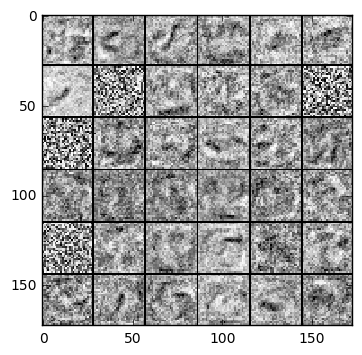

In [564]:
# Plot weights from first layer

# Weight tensor
with tf.variable_scope("ff_layer_0", reuse=True):
    W_0 = tf.get_variable("W", dtype=TF_DTYPE)

# Get weights
saver = tf.train.Saver()
with tf.Session() as session:
    saver.restore(session, model_fn)
    W_0 = W_0.eval()

image = Image.fromarray(plotting.tile_images(
    W_0.T, image_shape=(28, 28), tile_shape=(6, 6)
    ))
plt.imshow(image, cmap=plt.cm.Greys_r, interpolation="nearest")

## Convolutional neural network

In [565]:
tf.reset_default_graph()

# Training parameters
learning_rate = 0.001
n_epochs = 5
batch_size = 128
ff_keep_prob = 0.75

# Model parameters
n_input = 28*28
input_shape = [-1, 28, 28, 1]  # [n_data, height, width, d_in]
n_classes = 10
filter_shapes = [
    [5, 5, 1, 32],
    [5, 5, 32, 64]
    ]
pool_shapes = [
    [2, 2],
    [2, 2]
    ]
n_hiddens = [1024]

# Model
x = tf.placeholder(TF_DTYPE, [None, n_input])
y = tf.placeholder(TF_DTYPE, [None, n_classes])
keep_prob = tf.placeholder(TF_DTYPE)
cnn = blocks.build_cnn(x, input_shape, filter_shapes, pool_shapes, padding="SAME")
cnn = tf.contrib.layers.flatten(cnn)
cnn = blocks.build_feedforward(cnn, n_hiddens, keep_prob=keep_prob)
with tf.variable_scope("ff_layer_final"):
    cnn = blocks.build_linear(cnn, n_classes)

# Training tensors
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(cnn, y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

# Test tensors
correct_prediction = tf.equal(tf.argmax(cnn, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

In [566]:
# Train model

def mnist_train_feed_iterator():
    n_batches = int(mnist.train.num_examples/batch_size)
    for i_batch in xrange(n_batches):
        batch_x, batch_y = mnist.train.next_batch(batch_size)
        yield [batch_x, batch_y, ff_keep_prob]

def mnist_test_feed_iterator():
    yield [mnist.test.images, mnist.test.labels, 1.0]

model_fn = path.join(output_dir, "cnn.ckpt")

record_dict = training.train_fixed_epochs(
    n_epochs, optimizer, loss, mnist_train_feed_iterator,
    [x, y, keep_prob], accuracy, mnist_test_feed_iterator,
    save_model_fn=model_fn
    )

2016-10-05 14:27:59.949825
Epoch 0:

KeyboardInterrupt: 

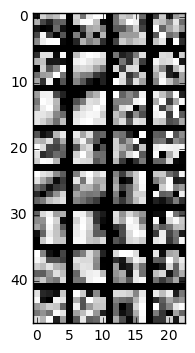

In [567]:
# Plot weights from first layer

# Weight tensor
with tf.variable_scope("cnn_layer_0", reuse=True):
    W_0 = tf.get_variable("W", dtype=TF_DTYPE)

# Get weights
saver = tf.train.Saver()
with tf.Session() as session:
    saver.restore(session, model_fn)
    W_0 = W_0.eval()

image = Image.fromarray(plotting.tile_images(
    W_0.T, image_shape=(28, 28), tile_shape=(8, 4)
    ))
plt.imshow(image, cmap=plt.cm.Greys_r, interpolation="nearest")

## Recurrent neural network

To train sequence models on MNIST, the columns of each image are considered a multivariate sequence.

In [568]:
tf.reset_default_graph()

# Training parameters
learning_rate = 0.001
n_epochs = 5
batch_size = 128

# Model parameters
n_input = 28
n_steps = 28  # timesteps
n_hidden = 128
n_classes = 10
rnn_type = "lstm"
rnn_keep_prob = 0.75

# Model
x = tf.placeholder(TF_DTYPE, [None, n_steps, n_input])
y = tf.placeholder(TF_DTYPE, [None, n_classes])
x_lengths = tf.fill([tf.shape(x)[0]], n_steps)
keep_prob = tf.placeholder(TF_DTYPE)
rnn_outputs, rnn_states = blocks.build_rnn(x, x_lengths, n_hidden, rnn_type=rnn_type, keep_prob=keep_prob)
if rnn_type == "lstm":
    rnn = rnn_states.h
elif rnn_type == "gru" or rnn_type == "rnn":
    rnn = rnn_states
else:
    assert False, "Invalid RNN type: {}".format(rnn_type)
with tf.variable_scope("ff_layer_final"):
    rnn = blocks.build_linear(rnn, n_classes)

# Training tensors
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(rnn, y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

# Test tensors
correct_prediction = tf.equal(tf.argmax(rnn, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))


In [569]:
# Train model

def mnist_train_feed_iterator():
    n_batches = int(mnist.train.num_examples/batch_size)
    for i_batch in xrange(n_batches):
        batch_x, batch_y = mnist.train.next_batch(batch_size)
        yield [np.reshape(batch_x, (-1, 28, 28)), batch_y, rnn_keep_prob]

def mnist_test_feed_iterator():
    yield [np.reshape(mnist.test.images, (-1, 28, 28)), mnist.test.labels, 1.0]

model_fn = path.join(output_dir, "rnn.ckpt")

record_dict = training.train_fixed_epochs(
    n_epochs, optimizer, loss, mnist_train_feed_iterator,
    [x, y, keep_prob], accuracy, mnist_test_feed_iterator,
    save_model_fn=model_fn
    )

2016-10-05 14:28:16.296648
Epoch 0: 27.260 sec, train loss: 0.57666, test loss: 0.93720
Epoch 1: 27.081 sec, train loss: 0.16835, test loss: 0.96030
Epoch 2:

KeyboardInterrupt: 

## Encoder-decoder version 1

This encoder-decoder is based on the *outback* implementation, where the output of the decoder is fed back as its own input.

In [19]:
tf.reset_default_graph()

# Training parameters
learning_rate = 0.001
n_epochs = 5
batch_size = 128

# Model parameters
n_input = 28
n_steps = 28  # timesteps
n_hidden = 128
rnn_type = "lstm"
# rnn_keep_prob = 1.0

# Model
x = tf.placeholder(TF_DTYPE, [None, n_steps, n_input])
x_lengths = tf.fill([tf.shape(x)[0]], n_steps)
network_tuple = seq2seq.build_encdec_outback(x, x_lengths, n_hidden, rnn_type=rnn_type)


# y = tf.placeholder(TF_DTYPE, [None, n_classes])
# x_lengths = tf.fill([tf.shape(x)[0]], n_steps)
# keep_prob = tf.placeholder(TF_DTYPE)
# rnn_outputs, rnn_states = blocks.build_rnn(x, x_lengths, n_hidden, rnn_type=rnn_type, keep_prob=keep_prob)
# if rnn_type == "lstm":
#     rnn = rnn_states.h
# elif rnn_type == "gru" or rnn_type == "rnn":
#     rnn = rnn_states
# else:
#     assert False, "Invalid RNN type: {}".format(rnn_type)
# with tf.variable_scope("ff_layer_final"):
#     rnn = blocks.build_linear(rnn, n_classes)

# # Training tensors
# loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(rnn, y))
# optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

# # Test tensors
# correct_prediction = tf.equal(tf.argmax(rnn, 1), tf.argmax(y, 1))
# accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

## Rubbish

In [12]:
np.min(mnist.test.images)

0.0

## Encoder-decoder version 2

This encoder-decoder is based on the *lazydynamic* implementation, where the encoder state is fed in as the input to the decoder at each time step.